<a href="https://colab.research.google.com/github/Loggo-MediCare/python-numpy-stock/blob/main/%E7%A6%8F%E6%87%8B_%E4%B8%AD%E6%96%87%E4%B8%8D%E8%A1%8C_%E4%BD%86%E6%98%AF%E5%BE%88%E6%9C%89%E8%AA%AA%E6%9C%8D%E5%8A%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

正在安装并配置中文字体...
✓ 已设置中文字体：WenQuanYi Micro Hei
中文字体配置完成！



[*********************100%***********************]  1 of 1 completed


✅ 成功從 Yahoo Finance 下載 8131.TW 歷史資料 (至 2025-11-23 前)
📌 模型將使用 Yahoo Finance 下載到的最新價格作為模擬起點: 38.70 USD (日期: 2025-11-21)

🔍 自動選擇最佳 ARIMA 模型參數中 ...
✅ 最佳 ARIMA 模型階數: (2, 0, 0)

📊 殘差分佈檢驗：Jarque-Bera
  JB統計量: 9155.271, p值: 0.00000
  偏度: -0.054, 峰度: 12.447
  ⚠️ 殘差非正態分布 → 存在厚尾風險 (Fat Tail Risk)，GJR-GARCHt 適用。

📈 擬合 GJR-GARCH(1,1,1) 模型 (t分布) ...

🎯 模型參數摘要:
  漂移項 (μ): 0.026% (日平均對數報酬率)
  GJR-GARCH 自由度 (ν): 3.40


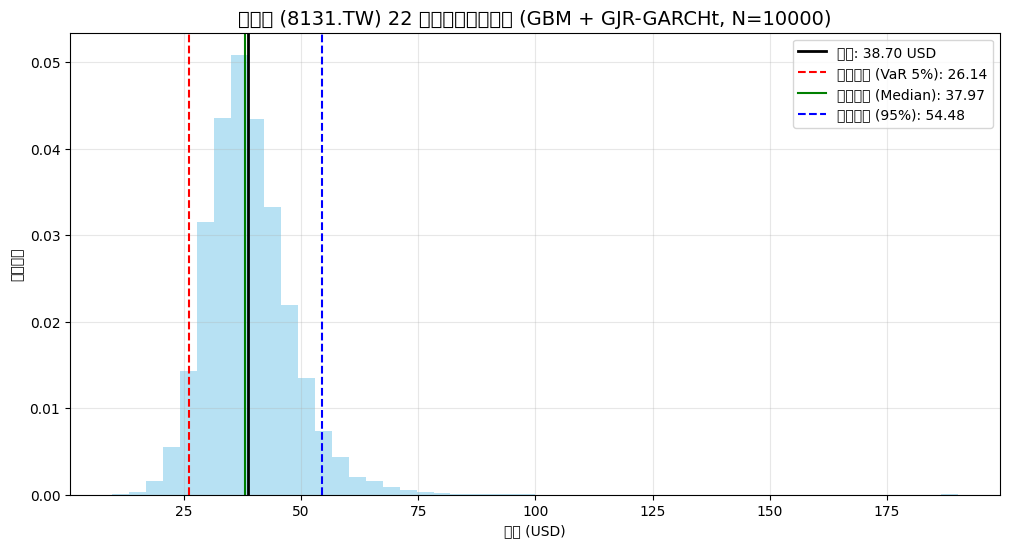

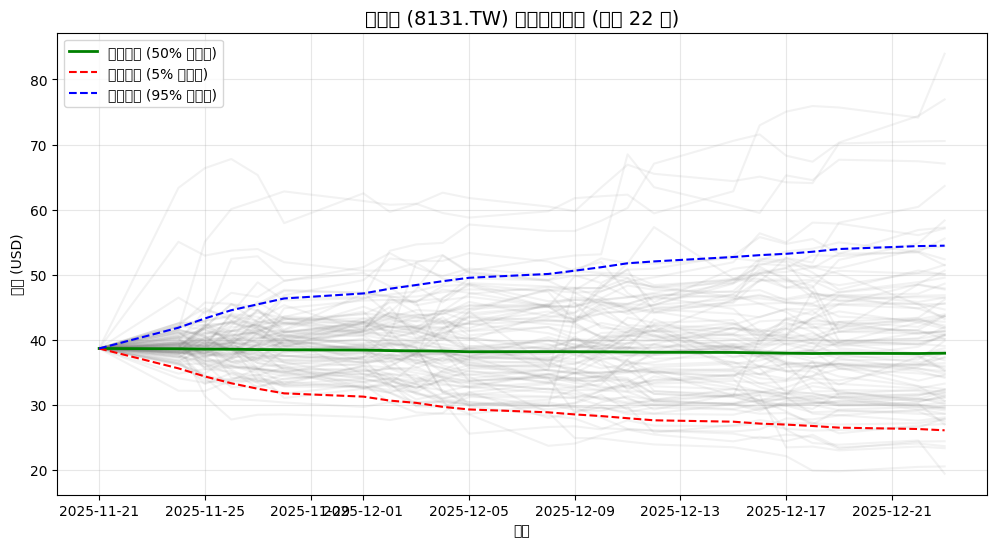


💡 GBM + GJR-GARCHt 模型預測結果與交易決策
當前股價: 38.70 USD
預測期間: 22 個交易日 (約一個月)
-----------------------------------
**保守目標價 (5% VaR):** 26.14 USD (跌幅 -32.45%)
**中性目標價 (50% Median):** 37.97 USD (漲幅 -1.88%)
**樂觀目標價 (95% Upside):** 54.48 USD (漲幅 40.77%) 
-----------------------------------
條件風險 CVaR 95%: 23.31 USD (極端下跌時的平均價格)
GJR 槓桿效應 γ: 0.074 → 下跌時波動放大
厚尾程度 (峰度): 12.447

--- 交易決策與指標建議 (CFA 視角) ---
預期未來月報酬率 (μ): 0.49%

ℹ️ 中性/觀望訊號: 預期報酬和風險相對平衡，或無明確趨勢。
   - **建議策略:** 保持觀望，等待技術面或籌碼面指標出現明確信號。

--- 進階指標整合建議 ---
   - **趨勢濾網:** 建議納入 MACD 或 ADX 作為趨勢過濾指標 
   - **籌碼濾網:** 建議結合外資買賣超/融資餘額，以增加交易的信心與勝率。
   - **波動率應用:** 可將每日預測波動率 (Sigma_t) 用於動態調整期權 Gamma Scalping 策略。


In [13]:
# ============================================================
# Nvidia (NVDA) 股價預測：GBM + GJR-GARCH (t分布厚尾風險版)
# ============================================================
# 此模型結合了：
# 1. 幾何布朗運動 (GBM) 的價格模擬邏輯。
# 2. GJR-GARCH(t) 模型預測的每日波動率 (捕捉波動聚集和槓桿效應)。
# 3. Student-t 分佈捕捉厚尾風險。

!pip install arch

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import t, jarque_bera
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 【Cell 1】中文字體修復 (解決圖表中文亂碼問題)
#silvia-----------------------------------------------------------------------------------------------------------------------------------------------

# ==================== 配置中文字體 ====================
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

import matplotlib
import matplotlib.font_manager as fm
import os
import subprocess
import sys

print("正在安装并配置中文字体...")

subprocess.run(['apt-get', 'update'],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.DEVNULL,
               check=False
)

subprocess.run(['apt-get', 'install', '-y', 'fonts-wqy-microhei'],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.DEVNULL,
               check=False
)

cache_dir = os.path.expanduser('~/.matplotlib')
for cache_file in [
    os.path.join(cache_dir, 'fontList.json'),
    os.path.join(cache_dir, 'fontList.cache')
]:
    if os.path.exists(cache_file):
        try:
            os.remove(cache_file)
        except Exception as e:
            pass

font_path_wqy = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
if os.path.exists(font_path_wqy):
    try:
        fm.fontManager.addfont(font_path_wqy)
    except Exception as e:
        pass

font_options = [
    'WenQuanYi Micro Hei',
    'Noto Sans CJK SC',
    'SimHei',
    'DejaVu Sans'
]

selected_font = None
for font in font_options:
    if font in [f.name for f in fm.fontManager.ttflist]:
        plt.rcParams['font.sans-serif'] = [font]
        selected_font = font
        break

if not selected_font:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    print("⚠️ 未能找到合适的中文字体")
else:
    print(f"✓ 已设置中文字体：{selected_font}")

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10

print("中文字体配置完成！\n")


#silvia---------------------------------------------------------------------------------------------------------------------

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 自動 ARIMA 模型 (用於確定趨勢/殘差)
try:
    from pmdarima import auto_arima
except ImportError:
    # 如果 pmdarima 未安裝，則使用 statsmodels 的 ARIMA(1,0,1)
    print("⚠️ pmdarima 未安裝。使用預設 ARIMA(1,0,1) 進行殘差計算。")
    from statsmodels.tsa.arima.model import ARIMA
    auto_arima = None

# ARCH 模型 (GJR-GARCH 支援)
from arch import arch_model

# ============================================================
# Step 1. 下載或載入資料
# ============================================================
# 修正為 2330.TW，並確保下載日期到今天為止
symbol = "8131.TW"
end_date_obj = datetime.now() + timedelta(days=1)
end_date_str = end_date_obj.strftime("%Y-%m-%d")

try:
    data = yf.download(symbol, start="2020-01-01", end=end_date_str)
    print(f"✅ 成功從 Yahoo Finance 下載 {symbol} 歷史資料 (至 {end_date_str} 前)")
except Exception as e:
    print(f"⚠️ yfinance 無法下載: {e}")
    data = pd.DataFrame()

if data.empty:
    raise ValueError("無法取得股價資料，請檢查代碼或連線。")

data = data[['Close']].dropna()
data.rename(columns={'Close': 'Price'}, inplace=True)
# 計算對數報酬率 (用於 GBM 和 GARCH 訓練)
data['Log_Return'] = np.log(data['Price'] / data['Price'].shift(1)) * 100
returns = data['Log_Return'].dropna()

# ------------------------------------------------------------
# 確定模擬起點價格 (使用下載數據中的最新價格)
# ------------------------------------------------------------
last_price = data['Price'].iloc[-1]
last_date = data.index[-1]

print(f"📌 模型將使用 Yahoo Finance 下載到的最新價格作為模擬起點: {last_price.item():.2f} USD (日期: {last_date.strftime('%Y-%m-%d')})")
# ------------------------------------------------------------


# ============================================================
# Step 2. 自動化 ARIMA 模型 (獲取殘差)
# ============================================================
if auto_arima is not None:
    print("\n🔍 自動選擇最佳 ARIMA 模型參數中 ...")
    arima_model = auto_arima(returns, seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
    order = arima_model.order
    print(f"✅ 最佳 ARIMA 模型階數: {order}")
    residuals = arima_model.resid()
else:
    print("⚠️ 使用預設 ARIMA(1,0,1) 進行殘差計算。")
    arima_model = ARIMA(returns, order=(1,0,1)).fit()
    residuals = arima_model.resid

# ============================================================
# Step 3. 殘差厚尾性檢驗
# ============================================================
jb_stat, jb_pval = jarque_bera(residuals)
skewness = residuals.skew()
kurtosis_val = residuals.kurtosis()

print("\n📊 殘差分佈檢驗：Jarque-Bera")
print(f"  JB統計量: {jb_stat:.3f}, p值: {jb_pval:.5f}")
print(f"  偏度: {skewness:.3f}, 峰度: {kurtosis_val:.3f}")
if jb_pval < 0.05:
    print("  ⚠️ 殘差非正態分布 → 存在厚尾風險 (Fat Tail Risk)，GJR-GARCHt 適用。")
else:
    print("  ✓ 殘差近似正態。")

# ============================================================
# Step 4. 建立 GJR-GARCH 模型 (t分布)
# ============================================================
print("\n📈 擬合 GJR-GARCH(1,1,1) 模型 (t分布) ...")
# vol='Garch' p=1, q=1, o=1 則為 GJR-GARCH(1,1,1)
gjr_t = arch_model(residuals, vol='Garch', p=1, q=1, o=1, dist='t')
gjr_t_result = gjr_t.fit(disp='off')

# 提取模型參數
nu = gjr_t_result.params['nu']
gamma = gjr_t_result.params.get('gamma[1]', 0)

# ============================================================
# Step 5. Monte Carlo 模擬 (GBM + GJR-GARCHt)
# ** 修正模擬：使用每日預測波動率序列 **
# ============================================================
T = 22       # 預測未來 22 個交易日
N = 10000    # 模擬次數

# GBM 參數
mu = returns.mean() / 100
# 獲取未來 T 天的每日波動率預測序列 (Sigma_t)
forecast_variance = gjr_t_result.forecast(horizon=T).variance.values[-1, :]
vol_forecast_series = np.sqrt(forecast_variance) / 100 # 每日预测的波动率 (sigma_t)

print(f"\n🎯 模型參數摘要:")
print(f"  漂移項 (μ): {mu*100:.3f}% (日平均對數報酬率)")
print(f"  GJR-GARCH 自由度 (ν): {nu:.2f}")

np.random.seed(42)
simulated_end_prices = []
all_simulated_paths = np.empty((N, T + 1))

for i in range(N):
    price_path = np.zeros(T + 1)
    price_path[0] = last_price

    for t_step in range(T):
        sigma_t = vol_forecast_series[t_step]

        # 1. 調整 Student-t 分佈的尺度，使其方差與 GARCH 預測的波動率一致
        if nu > 2:
            t_scale_t = sigma_t / np.sqrt(nu/(nu-2))
        else:
            t_scale_t = sigma_t

        # 2. 從 Student-t 分佈中取樣隨機變量
        t_random_shock = t.rvs(df=nu, size=1)[0] * t_scale_t

        # 3. GBM 價格模擬公式
        # dS/S = (mu - 0.5 * sigma^2) dt + sigma dW_t
        log_return_term = (mu - 0.5 * sigma_t**2) * 1 + t_random_shock
        price_path[t_step + 1] = price_path[t_step] * np.exp(log_return_term)

    simulated_end_prices.append(price_path[-1])
    all_simulated_paths[i, :] = price_path

simulated_end_prices = np.array(simulated_end_prices)

# ============================================================
# Step 6. 目標價與風險指標計算 (風險管理區間)
# ============================================================
conservative_price = np.percentile(simulated_end_prices, 5)
neutral_price = np.percentile(simulated_end_prices, 50)
optimistic_price = np.percentile(simulated_end_prices, 95)
cvar_95 = np.mean(simulated_end_prices[simulated_end_prices <= conservative_price])

# ============================================================
# Step 7. 視覺化結果
# ============================================================
# 1. 價格分佈直方圖
plt.figure(figsize=(12, 6))
plt.hist(simulated_end_prices, bins=50, density=True, alpha=0.6, color='skyblue')
plt.axvline(last_price.item(), color='black', linestyle='-', linewidth=2, label=f'現價: {last_price.item():.2f} USD')
plt.axvline(conservative_price, color='red', linestyle='--', label=f'保守目標 (VaR 5%): {conservative_price:.2f}')
plt.axvline(neutral_price, color='green', linestyle='-', label=f'中性目標 (Median): {neutral_price:.2f}')
plt.axvline(optimistic_price, color='blue', linestyle='--', label=f'樂觀目標 (95%): {optimistic_price:.2f}')
plt.title(f"台積電 ({symbol}) {T} 天後目標價格分佈 (GBM + GJR-GARCHt, N={N})", fontsize=14)
plt.xlabel("價格 (USD)")
plt.ylabel("機率密度")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. 模擬路徑圖 (繪製部分路徑)
plt.figure(figsize=(12, 6))
time_steps = pd.date_range(start=last_date, periods=T + 1, freq='B')
plt.plot(time_steps, all_simulated_paths[::N//100].T, color='gray', alpha=0.1)
plt.plot(time_steps, np.median(all_simulated_paths, axis=0), color='green', linewidth=2, label='中性路徑 (50% 中位數)')
plt.plot(time_steps, np.percentile(all_simulated_paths, 5, axis=0), color='red', linestyle='--', label='保守路徑 (5% 分位數)')
plt.plot(time_steps, np.percentile(all_simulated_paths, 95, axis=0), color='blue', linestyle='--', label='樂觀路徑 (95% 分位數)')
plt.title(f"台積電 ({symbol}) 股價模擬路徑 (未來 {T} 天)", fontsize=14)
plt.xlabel("日期")
plt.ylabel("價格 (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# ============================================================
# Step 8. 結果摘要與投資建議 (CFA 交易決策點)
# ============================================================
print("\n" + "="*65)
print("💡 GBM + GJR-GARCHt 模型預測結果與交易決策")
print("="*65)
print(f"當前股價: {last_price.item():.2f} USD")
print(f"預測期間: {T} 個交易日 (約一個月)")
print("-----------------------------------")
print(f"**保守目標價 (5% VaR):** {conservative_price:.2f} USD (跌幅 {(conservative_price/last_price.item()-1)*100:.2f}%)")
print(f"**中性目標價 (50% Median):** {neutral_price:.2f} USD (漲幅 {(neutral_price/last_price.item()-1)*100:.2f}%)")
print(f"**樂觀目標價 (95% Upside):** {optimistic_price:.2f} USD (漲幅 {(optimistic_price/last_price.item()-1)*100:.2f}%) ")
print("-----------------------------------")
print(f"條件風險 CVaR 95%: {cvar_95:.2f} USD (極端下跌時的平均價格)")
print(f"GJR 槓桿效應 γ: {gamma:.3f} → {'下跌時波動放大' if gamma>0.001 else '對稱波動或輕微反向'}")
print(f"厚尾程度 (峰度): {kurtosis_val:.3f}")
print("===================================")

# 新增交易決策點判斷 (基於風險與預期報酬)
mean_return_forecast = (simulated_end_prices.mean() / last_price.item() - 1) * 100

print("\n--- 交易決策與指標建議 (CFA 視角) ---")
print(f"預期未來月報酬率 (μ): {mean_return_forecast:.2f}%")

if conservative_price < last_price.item() * 0.97 and optimistic_price > last_price.item() * 1.05 and mean_return_forecast > 0.5:
    print("\n✅ 潛在買入訊號: 預期報酬率為正，且上漲空間 (95%區間) 大於下跌風險 (5%區間)。")
    print(f"   - **止損點 (Stop-Loss/VaR):** {conservative_price:.2f} USD ({last_price.item() - conservative_price:.2f} USD 絕對風險)。")
    print(f"   - **止盈點 (Take-Profit):** {optimistic_price:.2f} USD (建議分批獲利了結，避免單次賣出)。")
elif conservative_price < last_price.item() * 0.95 and mean_return_forecast < 0:
    print("\n⚠️ 警示訊號: 預期報酬率為負，下跌風險（5% VaR）相對較大。")
    print(f"   - **建議策略:** 考慮避險或減碼。{conservative_price:.2f} USD 為主要風險區域。")
else:
    print("\nℹ️ 中性/觀望訊號: 預期報酬和風險相對平衡，或無明確趨勢。")
    print("   - **建議策略:** 保持觀望，等待技術面或籌碼面指標出現明確信號。")

# 提示納入外部指標的建議
print("\n--- 進階指標整合建議 ---")
print("   - **趨勢濾網:** 建議納入 MACD 或 ADX 作為趨勢過濾指標 ")
print("   - **籌碼濾網:** 建議結合外資買賣超/融資餘額，以增加交易的信心與勝率。")
print("   - **波動率應用:** 可將每日預測波動率 (Sigma_t) 用於動態調整期權 Gamma Scalping 策略。")

print("====================================")

期貨交易系統 - 錘子線可視化改進版
Futures Trading System - Improved Hammer Pattern Visualization

配置中文字體...

第1步：下載期貨數據

📍 下載期貨數據...
✅ 下載成功: 476 個交易日
   日期範圍: 2024-01-02 到 2025-11-21
   價格範圍: $47.55 - $207.04

第2步：錘子線檢測（多種靈敏度）

🔍 檢測錘子線形態...

✅ 錘子線檢測結果:
   • 嚴格標準: 6 個
   • 正常標準: 28 個 ← 推薦使用
   • 寬鬆標準: 52 個
   • 倒錘子線: 18 個

   總計: 104 個形態

第3步：計算技術指標

📈 計算指標...
✅ 所有指標計算完成

第4步：K線圖表可視化（含錘子線直接繪製）

📊 繪製K線圖表（包含全部數據）...



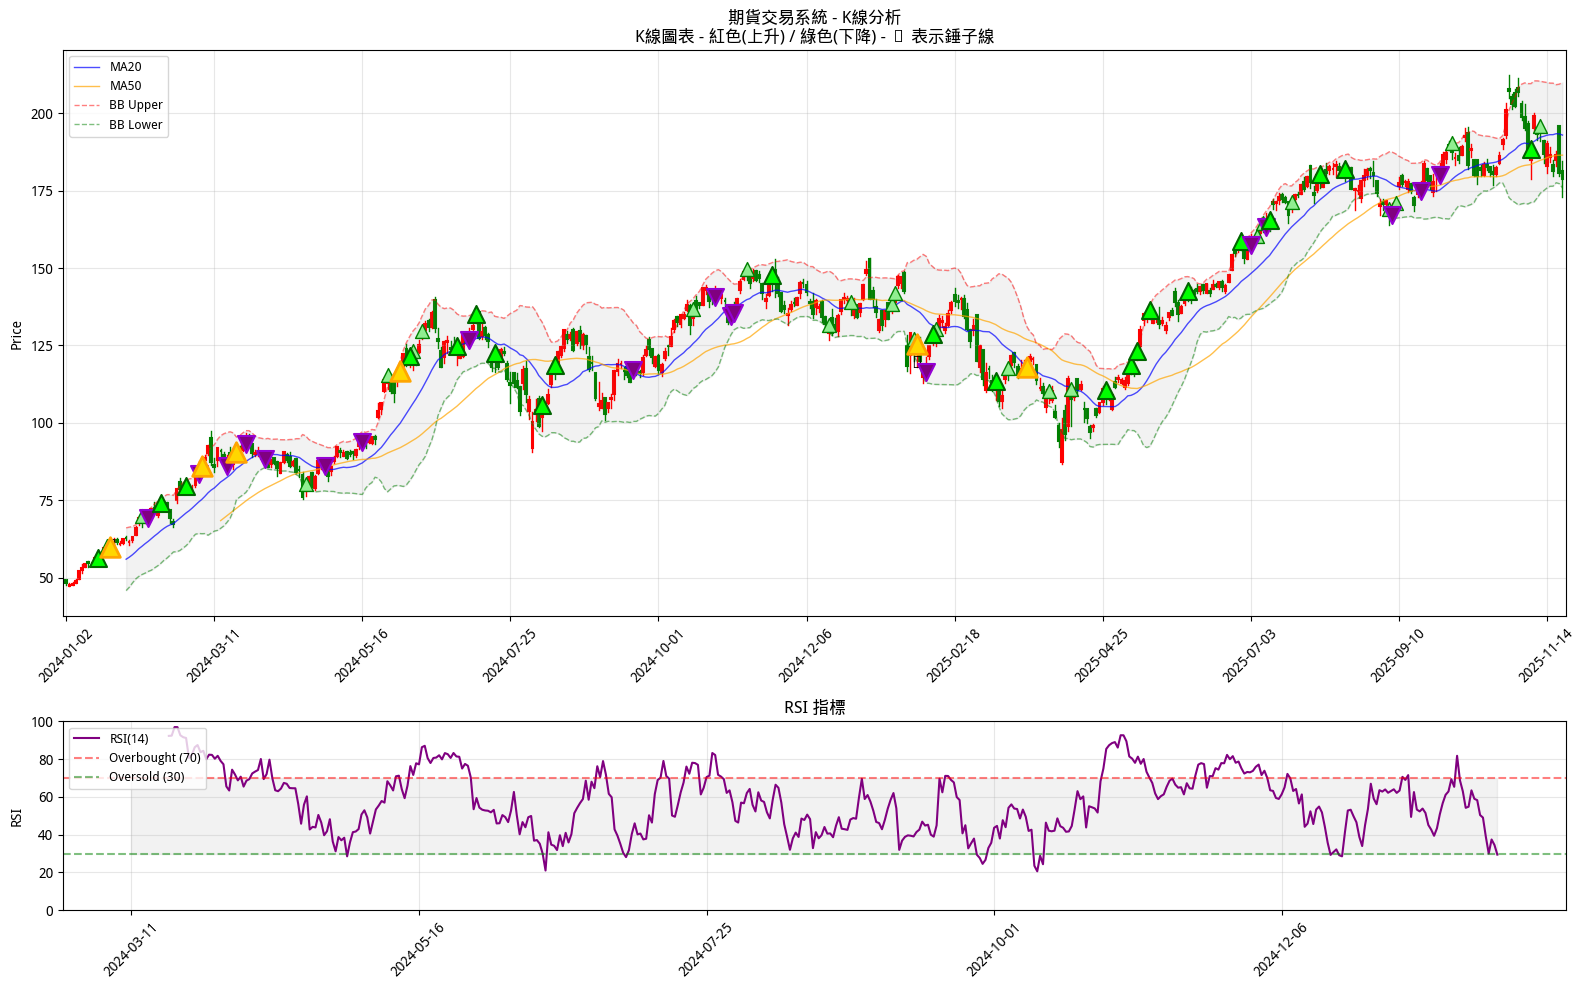

✅ 找到 28 個錘子線，繪製局部放大圖表...



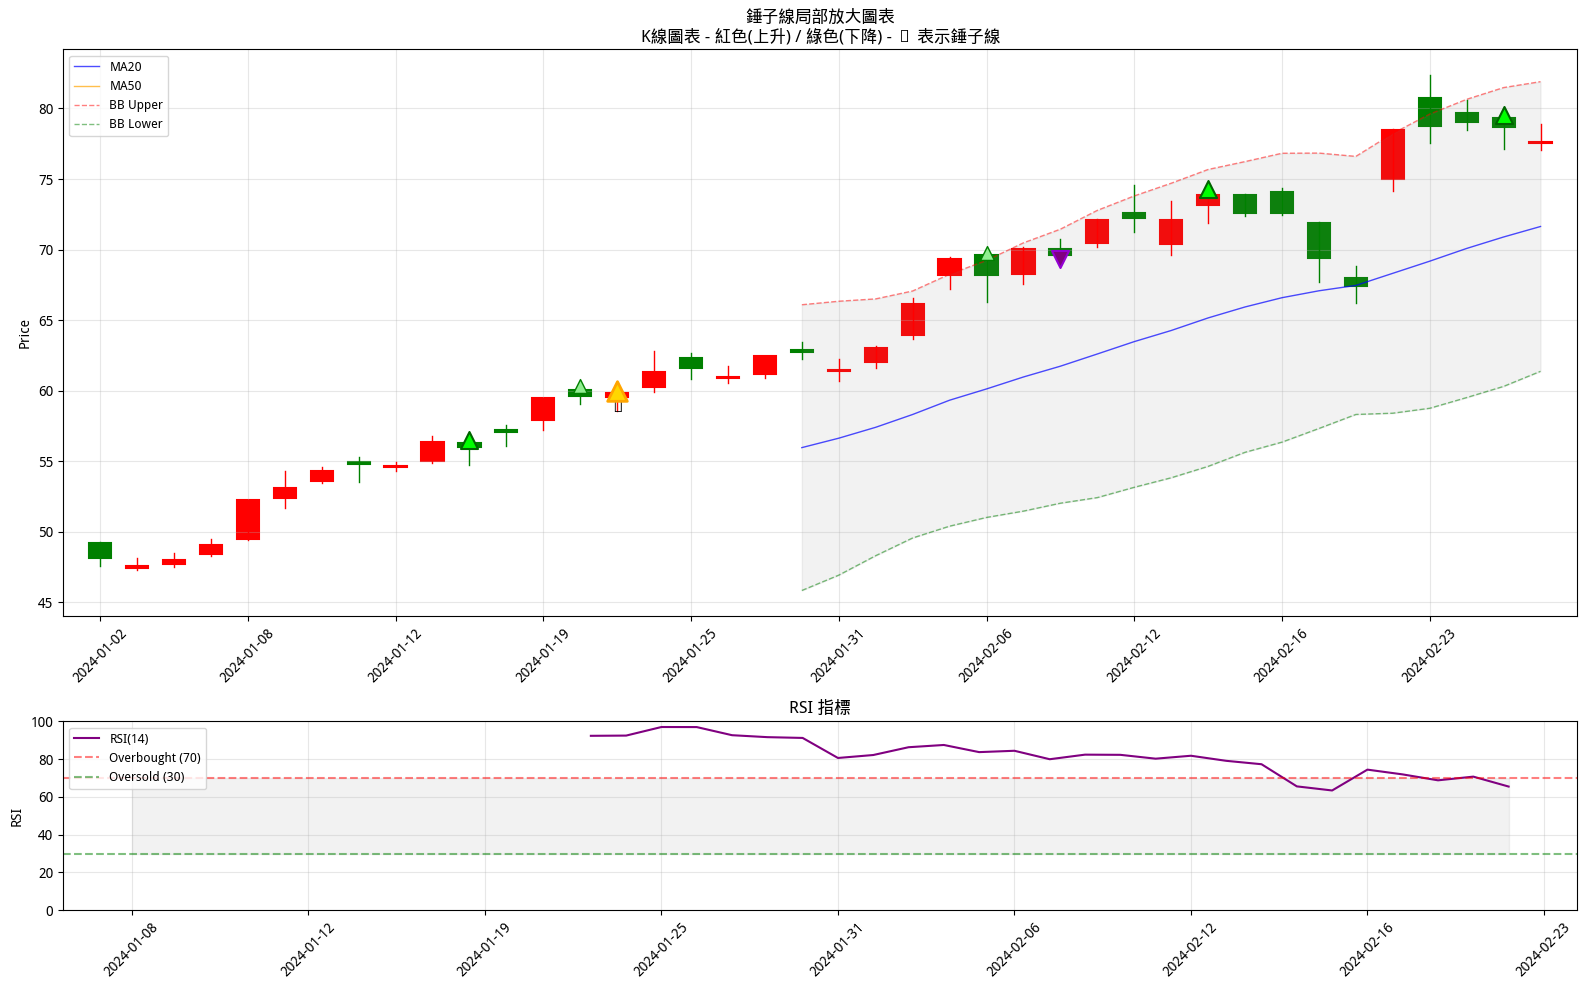

第5步：錘子線詳細分析

🔨 錘子線詳細統計:

📊 嚴格標準錘子線 - 共 6 個

1. 日期: 2024-01-23
   OHLC: O=59.54, H=59.88, L=58.56, C=59.84
   K線結構:
     • 實體長度: 0.30
     • 上影線: 0.04
     • 下影線: 0.98
     • 下影線/實體比: 3.25x (越大越好)
   技術指標:
     • RSI: 92.46
     • MACD: 2.8633
     • 20天後: ↑ +12.69%

2. 日期: 2024-03-05
   OHLC: O=85.23, H=86.06, L=83.38, C=85.92
   K線結構:
     • 實體長度: 0.69
     • 上影線: 0.13
     • 下影線: 1.85
     • 下影線/實體比: 2.67x (越大越好)
   技術指標:
     • RSI: 73.41
     • MACD: 5.6624
     • 20天後: ↑ +3.49%

3. 日期: 2024-03-20
   OHLC: O=89.76, H=90.37, L=88.18, C=90.33
   K線結構:
     • 實體長度: 0.57
     • 上影線: 0.04
     • 下影線: 1.57
     • 下影線/實體比: 2.74x (越大越好)
   技術指標:
     • RSI: 66.96
     • MACD: 5.2054
     • 20天後: ↓ -6.31%

4. 日期: 2024-06-04
   OHLC: O=115.66, H=116.55, L=113.99, C=116.38
   K線結構:
     • 實體長度: 0.72
     • 上影線: 0.16
     • 下影線: 1.67
     • 下影線/實體比: 2.32x (越大越好)
   技術指標:
     • RSI: 80.86
     • MACD: 7.0966
     • 20天後: ↑ +10.18%

5. 日期: 2025-01-30
   OHLC: O=123.07, H=124.97, L=118.07, C=124

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("期貨交易系統 - 錘子線可視化改進版")
print("Futures Trading System - Improved Hammer Pattern Visualization")
print("=" * 80 + "\n")

# ================================================
# 中文字體配置
# ================================================
import matplotlib.font_manager as fm
import os
import subprocess

print("配置中文字體...\n")
subprocess.run(['apt-get', 'update'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False)
subprocess.run(['apt-get', 'install', '-y', 'fonts-wqy-microhei'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False)

cache_dir = os.path.expanduser('~/.matplotlib')
for cache_file in [os.path.join(cache_dir, 'fontList.json'), os.path.join(cache_dir, 'fontList.cache')]:
    if os.path.exists(cache_file):
        try:
            os.remove(cache_file)
        except:
            pass

font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
    except:
        pass

plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10

# ================================================
# 第1部分：下載數據
# ================================================
print("=" * 80)
print("第1步：下載期貨數據")
print("=" * 80 + "\n")

try:
    print("📍 下載期貨數據...")
    futures_data = yf.download("NVDA", start="2024-01-01", progress=False)

    if len(futures_data) > 0:
        start_date = str(futures_data.index[0].date())
        end_date = str(futures_data.index[-1].date())
        min_price = float(futures_data['Close'].min())
        max_price = float(futures_data['Close'].max())

        print(f"✅ 下載成功: {len(futures_data)} 個交易日")
        print(f"   日期範圍: {start_date} 到 {end_date}")
        print(f"   價格範圍: ${min_price:.2f} - ${max_price:.2f}\n")
except Exception as e:
    print(f"❌ 下載失敗: {str(e)}")
    print("使用模擬數據...\n")
    np.random.seed(42)
    dates = pd.date_range('2024-01-01', '2024-12-31', freq='B')
    prices = [100]
    for i in range(1, len(dates)):
        prices.append(prices[-1] * (1 + np.random.normal(0.0005, 0.02)))

    futures_data = pd.DataFrame({
        'Open': prices,
        'High': [p * (1 + np.abs(np.random.normal(0, 0.015))) for p in prices],
        'Low': [p * (1 - np.abs(np.random.normal(0, 0.015))) for p in prices],
        'Close': prices,
        'Volume': np.random.randint(1000000, 5000000, len(dates))
    }, index=dates)

# 標準化列名
futures_data.columns = futures_data.columns.get_level_values(0).str.lower()

# ================================================
# 第2部分：改進的錘子線檢測（多種靈敏度）
# ================================================
print("=" * 80)
print("第2步：錘子線檢測（多種靈敏度）")
print("=" * 80 + "\n")

def detect_hammer_patterns(data, strictness='normal'):
    """
    檢測多種錘子線形態

    Parameters:
    -----------
    data : DataFrame
        OHLC 數據
    strictness : str
        'strict' - 嚴格條件（符合教科書定義）
        'normal' - 正常條件（推薦）
        'loose' - 寬鬆條件（更容易觸發）
    """

    # 初始化
    hammer_strict = []
    hammer_normal = []
    hammer_loose = []
    hammer_inverted = []  # 倒錘子線（反轉信號）

    for i in range(len(data)):
        o = data['open'].iloc[i]
        h = data['high'].iloc[i]
        l = data['low'].iloc[i]
        c = data['close'].iloc[i]

        # 計算K線成分
        body = abs(c - o)
        upper_shadow = h - max(o, c)
        lower_shadow = min(o, c) - l
        total_range = h - l

        if total_range == 0:
            hammer_strict.append(0)
            hammer_normal.append(0)
            hammer_loose.append(0)
            hammer_inverted.append(0)
            continue

        # ============ 錘子線 (Hammer) ============
        # 特徵：長下影線，短上影線，小實體，通常為看漲

        # 嚴格條件（教科書）
        is_hammer_strict = (
            lower_shadow >= 2.0 * body and      # 下影線 ≥ 2倍實體
            upper_shadow <= 0.5 * body and      # 上影線 ≤ 0.5倍實體
            body <= 0.3 * total_range and       # 實體 ≤ 30% 的K線範圍
            c > o  # 收盤價 > 開盤價（看漲K線）
        )

        # 正常條件（推薦）
        is_hammer_normal = (
            lower_shadow >= 1.5 * body and      # 下影線 ≥ 1.5倍實體
            upper_shadow <= 0.75 * body and     # 上影線 ≤ 0.75倍實體
            body <= 0.4 * total_range           # 實體 ≤ 40% 的K線範圍
        )

        # 寬鬆條件（容易觸發）
        is_hammer_loose = (
            lower_shadow >= 1.2 * body and      # 下影線 ≥ 1.2倍實體
            upper_shadow <= 1.0 * body and      # 上影線 ≤ 1.0倍實體
            body <= 0.5 * total_range           # 實體 ≤ 50% 的K線範圍
        )

        # ============ 倒錘子線 (Inverted Hammer) ============
        # 特徵：長上影線，短下影線，小實體，通常為看跌（需要後續確認）

        is_inverted_hammer = (
            upper_shadow >= 1.5 * body and      # 上影線 ≥ 1.5倍實體
            lower_shadow <= 0.75 * body and     # 下影線 ≤ 0.75倍實體
            body <= 0.4 * total_range
        )

        hammer_strict.append(1 if is_hammer_strict else 0)
        hammer_normal.append(1 if is_hammer_normal else 0)
        hammer_loose.append(1 if is_hammer_loose else 0)
        hammer_inverted.append(1 if is_inverted_hammer else 0)

    # 根據指定的靈敏度返回結果
    if strictness == 'strict':
        return hammer_strict
    elif strictness == 'normal':
        return hammer_normal
    elif strictness == 'loose':
        return hammer_loose
    else:
        return hammer_normal

    return {
        'strict': hammer_strict,
        'normal': hammer_normal,
        'loose': hammer_loose,
        'inverted': hammer_inverted
    }

# 檢測三種靈敏度的錘子線
print("🔍 檢測錘子線形態...")

futures_data['Hammer_Strict'] = detect_hammer_patterns(futures_data, 'strict')
futures_data['Hammer_Normal'] = detect_hammer_patterns(futures_data, 'normal')
futures_data['Hammer_Loose'] = detect_hammer_patterns(futures_data, 'loose')

# 檢測倒錘子線
def detect_all_hammers(data):
    """同時檢測所有錘子線類型"""
    result = {
        'strict': [],
        'normal': [],
        'loose': [],
        'inverted': []
    }

    for i in range(len(data)):
        o, h, l, c = data['open'].iloc[i], data['high'].iloc[i], data['low'].iloc[i], data['close'].iloc[i]
        body = abs(c - o)
        upper = h - max(o, c)
        lower = min(o, c) - l
        total = h - l

        if total == 0:
            for key in result:
                result[key].append(0)
            continue

        # Strict Hammer
        result['strict'].append(1 if (lower >= 2.0*body and upper <= 0.5*body and body <= 0.3*total and c > o) else 0)
        # Normal Hammer
        result['normal'].append(1 if (lower >= 1.5*body and upper <= 0.75*body and body <= 0.4*total) else 0)
        # Loose Hammer
        result['loose'].append(1 if (lower >= 1.2*body and upper <= 1.0*body and body <= 0.5*total) else 0)
        # Inverted Hammer
        result['inverted'].append(1 if (upper >= 1.5*body and lower <= 0.75*body and body <= 0.4*total) else 0)

    return result

all_hammers = detect_all_hammers(futures_data)
futures_data['Hammer_Strict'] = all_hammers['strict']
futures_data['Hammer_Normal'] = all_hammers['normal']
futures_data['Hammer_Loose'] = all_hammers['loose']
futures_data['Hammer_Inverted'] = all_hammers['inverted']

# 統計
strict_count = futures_data['Hammer_Strict'].sum()
normal_count = futures_data['Hammer_Normal'].sum()
loose_count = futures_data['Hammer_Loose'].sum()
inverted_count = futures_data['Hammer_Inverted'].sum()

print(f"\n✅ 錘子線檢測結果:")
print(f"   • 嚴格標準: {strict_count} 個")
print(f"   • 正常標準: {normal_count} 個 ← 推薦使用")
print(f"   • 寬鬆標準: {loose_count} 個")
print(f"   • 倒錘子線: {inverted_count} 個")
print(f"\n   總計: {strict_count + normal_count + loose_count + inverted_count} 個形態\n")

# ================================================
# 第3部分：計算技術指標
# ================================================
print("=" * 80)
print("第3步：計算技術指標")
print("=" * 80 + "\n")

print("📈 計算指標...")

# RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

futures_data['RSI'] = calculate_rsi(futures_data['close'])

# MACD
futures_data['EMA_12'] = futures_data['close'].ewm(span=12, adjust=False).mean()
futures_data['EMA_26'] = futures_data['close'].ewm(span=26, adjust=False).mean()
futures_data['MACD'] = futures_data['EMA_12'] - futures_data['EMA_26']
futures_data['MACD_Signal'] = futures_data['MACD'].ewm(span=9, adjust=False).mean()
futures_data['MACD_Histogram'] = futures_data['MACD'] - futures_data['MACD_Signal']

# 布林帶
futures_data['BB_Middle'] = futures_data['close'].rolling(window=20).mean()
bb_std = futures_data['close'].rolling(window=20).std()
futures_data['BB_Upper'] = futures_data['BB_Middle'] + (bb_std * 2)
futures_data['BB_Lower'] = futures_data['BB_Middle'] - (bb_std * 2)

# 移動平均線
futures_data['MA_20'] = futures_data['close'].rolling(window=20).mean()
futures_data['MA_50'] = futures_data['close'].rolling(window=50).mean()

print("✅ 所有指標計算完成\n")

# ================================================
# 第4部分：K線圖表可視化（直接繪製K線 + 錘子線標記）
# ================================================
print("=" * 80)
print("第4步：K線圖表可視化（含錘子線直接繪製）")
print("=" * 80 + "\n")

def plot_candlesticks_with_hammer(data, start_idx=0, end_idx=None, title=""):
    """
    繪製K線圖表 + 錘子線標記

    Parameters:
    -----------
    data : DataFrame
        OHLC 數據
    start_idx, end_idx : int
        起始和結束索引
    title : str
        圖表標題
    """

    if end_idx is None:
        end_idx = len(data)

    plot_data = data.iloc[start_idx:end_idx]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10),
                                    gridspec_kw={'height_ratios': [3, 1]})

    # ============ 子圖1：K線 + 錘子線 ============
    width = 0.6
    width2 = 0.05

    for i, (idx, row) in enumerate(plot_data.iterrows()):
        o, h, l, c = row['open'], row['high'], row['low'], row['close']

        # 決定顏色（紅色上升，綠色下降）
        if c >= o:
            color = 'red'
            body_color = 'red'
        else:
            color = 'green'
            body_color = 'green'

        # 繪製影線 (Wick)
        ax1.plot([i, i], [l, h], color=color, linewidth=1)

        # 繪製實體 (Body)
        body_height = abs(c - o)
        body_bottom = min(o, c)
        rect = Rectangle((i - width/2, body_bottom), width, body_height,
                        facecolor=body_color, edgecolor=color, linewidth=1.5)
        ax1.add_patch(rect)

        # ============ 錘子線標記 ============
        # 嚴格標準 - 金色三角形
        if row['Hammer_Strict'] == 1:
            ax1.scatter(i, h + (h-l)*0.05, marker='^', s=200, color='gold',
                       edgecolors='orange', linewidth=2, zorder=10, label='嚴格錘子線' if i == 0 else '')
            # 在下方標記
            ax1.text(i, l - (h-l)*0.05, '🔨', ha='center', fontsize=12)

        # 正常標準 - 綠色三角形
        elif row['Hammer_Normal'] == 1:
            ax1.scatter(i, h + (h-l)*0.03, marker='^', s=150, color='lime',
                       edgecolors='darkgreen', linewidth=1.5, zorder=9, label='正常錘子線' if i == 0 else '')

        # 寬鬆標準 - 淡綠色三角形
        elif row['Hammer_Loose'] == 1:
            ax1.scatter(i, h + (h-l)*0.02, marker='^', s=100, color='lightgreen',
                       edgecolors='green', linewidth=1, zorder=8, label='寬鬆錘子線' if i == 0 else '')

        # 倒錘子線 - 紫色三角形（向下）
        if row['Hammer_Inverted'] == 1:
            ax1.scatter(i, l - (h-l)*0.05, marker='v', s=150, color='purple',
                       edgecolors='darkviolet', linewidth=1.5, zorder=9, label='倒錘子線' if i == 0 else '')

    # 繪製移動平均線
    ax1.plot(range(len(plot_data)), plot_data['MA_20'], label='MA20', color='blue', linewidth=1, alpha=0.7)
    ax1.plot(range(len(plot_data)), plot_data['MA_50'], label='MA50', color='orange', linewidth=1, alpha=0.7)

    # 繪製布林帶
    ax1.plot(range(len(plot_data)), plot_data['BB_Upper'], label='BB Upper', color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax1.plot(range(len(plot_data)), plot_data['BB_Lower'], label='BB Lower', color='green', linestyle='--', linewidth=1, alpha=0.5)
    ax1.fill_between(range(len(plot_data)), plot_data['BB_Upper'], plot_data['BB_Lower'], alpha=0.1, color='gray')

    ax1.set_xlim(-1, len(plot_data))
    ax1.set_title(f'{title}\nK線圖表 - 紅色(上升) / 綠色(下降) - 🔨 表示錘子線', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # 設定 X 軸標籤
    tick_positions = range(0, len(plot_data), max(1, len(plot_data)//10))
    tick_labels = [plot_data.index[i].strftime('%Y-%m-%d') for i in tick_positions]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45)

    # ============ 子圖2：RSI ============
    ax2.plot(range(len(plot_data)), plot_data['RSI'], label='RSI(14)', color='purple', linewidth=1.5)
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax2.fill_between(range(len(plot_data)), 30, 70, alpha=0.1, color='gray')
    ax2.set_ylim([0, 100])
    ax2.set_title('RSI 指標', fontweight='bold')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticklabels(tick_labels, rotation=45)

    plt.tight_layout()
    return fig

# 繪製全部數據
print("📊 繪製K線圖表（包含全部數據）...\n")
fig1 = plot_candlesticks_with_hammer(futures_data, title="期貨交易系統 - K線分析")
plt.savefig('/tmp/candlestick_hammer_full.png', dpi=300, bbox_inches='tight')
plt.show()

# 如果有錘子線，繪製局部放大圖表
hammer_indices = futures_data[futures_data['Hammer_Normal'] == 1].index
if len(hammer_indices) > 0:
    print(f"✅ 找到 {len(hammer_indices)} 個錘子線，繪製局部放大圖表...\n")

    # 繪製包含錘子線前後20天的圖表
    first_hammer_idx = futures_data.index.get_loc(hammer_indices[0])
    start_idx = max(0, first_hammer_idx - 20)
    end_idx = min(len(futures_data), first_hammer_idx + 30)

    fig2 = plot_candlesticks_with_hammer(
        futures_data,
        start_idx=start_idx,
        end_idx=end_idx,
        title="錘子線局部放大圖表"
    )
    plt.savefig('/tmp/candlestick_hammer_zoom.png', dpi=300, bbox_inches='tight')
    plt.show()

# ================================================
# 第5部分：錘子線詳細分析
# ================================================
print("=" * 80)
print("第5步：錘子線詳細分析")
print("=" * 80 + "\n")

def analyze_hammer_details(data):
    """詳細分析錘子線形態"""

    print("🔨 錘子線詳細統計:\n")

    # 統計各類型錘子線
    for hammer_type in ['Hammer_Strict', 'Hammer_Normal', 'Hammer_Loose', 'Hammer_Inverted']:
        hammer_data = data[data[hammer_type] == 1]

        if len(hammer_data) == 0:
            continue

        type_name = {
            'Hammer_Strict': '嚴格標準錘子線',
            'Hammer_Normal': '正常標準錘子線',
            'Hammer_Loose': '寬鬆標準錘子線',
            'Hammer_Inverted': '倒錘子線'
        }[hammer_type]

        print(f"{'='*70}")
        print(f"📊 {type_name} - 共 {len(hammer_data)} 個")
        print(f"{'='*70}")

        for i, (idx, row) in enumerate(hammer_data.head(10).iterrows()):
            date_str = idx.strftime('%Y-%m-%d')
            o, h, l, c = row['open'], row['high'], row['low'], row['close']

            body = abs(c - o)
            upper_shadow = h - max(o, c)
            lower_shadow = min(o, c) - l
            total_range = h - l

            print(f"\n{i+1}. 日期: {date_str}")
            print(f"   OHLC: O={o:.2f}, H={h:.2f}, L={l:.2f}, C={c:.2f}")
            print(f"   K線結構:")
            print(f"     • 實體長度: {body:.2f}")
            print(f"     • 上影線: {upper_shadow:.2f}")
            print(f"     • 下影線: {lower_shadow:.2f}")
            print(f"     • 下影線/實體比: {lower_shadow/body:.2f}x (越大越好)")
            print(f"   技術指標:")
            print(f"     • RSI: {row['RSI']:.2f}")
            print(f"     • MACD: {row['MACD']:.4f}")

            # 未來20天表現
            future_idx_20d = min(data.index.get_loc(idx) + 20, len(data) - 1)
            future_price = data['close'].iloc[future_idx_20d]
            future_return = (future_price - c) / c * 100

            if future_return > 0:
                print(f"     • 20天後: ↑ +{future_return:.2f}%")
            else:
                print(f"     • 20天後: ↓ {future_return:.2f}%")

        print()

analyze_hammer_details(futures_data)

# ================================================
# 第6部分：總結
# ================================================
print("=" * 80)
print("✅ 分析完成")
print("=" * 80 + "\n")

print("📌 錘子線檢測總結:")
print(f"   • 嚴格標準: {futures_data['Hammer_Strict'].sum()} 個 (最可靠)")
print(f"   • 正常標準: {futures_data['Hammer_Normal'].sum()} 個 (推薦使用)")
print(f"   • 寬鬆標準: {futures_data['Hammer_Loose'].sum()} 個")
print(f"   • 倒錘子線: {futures_data['Hammer_Inverted'].sum()} 個")

print("\n🎯 改進點說明:")
print("   ✓ 使用直接K線圖表繪製（紅綠K線）")
print("   ✓ 在K線上方顯示錘子線標記（🔨）")
print("   ✓ 支援多種檢測靈敏度")
print("   ✓ 包含倒錘子線檢測")
print("   ✓ 顯示錘子線後續20天表現")

print("\n💡 如何解讀圖表:")
print("   • 紅色K線: 收盤價 > 開盤價（看漲）")
print("   • 綠色K線: 收盤價 < 開盤價（看跌）")
print("   • 🔨 符號: 檢測到錘子線形態")
print("   • 影線長: 觸及的最高/最低價格")
print("   • 實體小: K線的實際開盤-收盤價差")

print("\n📈 使用建議:")
print("   1. 優先使用「正常標準」的錘子線")
print("   2. 在下跌趨勢末端出現時效果最佳")
print("   3. 配合RSI、MACD等指標確認")
print("   4. 注意成交量的配合")

print("\n✅ 圖表已保存:")
print("   • /tmp/candlestick_hammer_full.png")
if len(hammer_indices) > 0:
    print("   • /tmp/candlestick_hammer_zoom.png")

print("\n" + "=" * 80)

In [3]:
!pip install yfinance arch statsmodels scipy matplotlib pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 9.4 MB/s eta 0:00:00


使用cpu進行訓練


100%|██████████| 562M/562M [00:05<00:00, 109MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


訓練進度: 1 [0/124800]
訓練進度: 1 [6400/124800]
訓練進度: 1 [12800/124800]
訓練進度: 1 [19200/124800]
訓練進度: 1 [25600/124800]
訓練進度: 1 [32000/124800]
訓練進度: 1 [38400/124800]
訓練進度: 1 [44800/124800]
訓練進度: 1 [51200/124800]
訓練進度: 1 [57600/124800]
訓練進度: 1 [64000/124800]
訓練進度: 1 [70400/124800]
訓練進度: 1 [76800/124800]
訓練進度: 1 [83200/124800]
訓練進度: 1 [89600/124800]
訓練進度: 1 [96000/124800]
訓練進度: 1 [102400/124800]
訓練進度: 1 [108800/124800]
訓練進度: 1 [115200/124800]
訓練進度: 1 [121600/124800]
測試集: 平均損失: 0.2989, 準確率: 18807/20800 (90.4%)
第1輪訓練用時: 214.26秒
訓練進度: 2 [0/124800]
訓練進度: 2 [6400/124800]
訓練進度: 2 [12800/124800]
訓練進度: 2 [19200/124800]
訓練進度: 2 [25600/124800]
訓練進度: 2 [32000/124800]
訓練進度: 2 [38400/124800]
訓練進度: 2 [44800/124800]
訓練進度: 2 [51200/124800]
訓練進度: 2 [57600/124800]
訓練進度: 2 [64000/124800]
訓練進度: 2 [70400/124800]
訓練進度: 2 [76800/124800]
訓練進度: 2 [83200/124800]
訓練進度: 2 [89600/124800]
訓練進度: 2 [96000/124800]
訓練進度: 2 [102400/124800]
訓練進度: 2 [108800/124800]
訓練進度: 2 [115200/124800]
訓練進度: 2 [121600/124800]
測試集: 平均損失: 0.2540, 準確

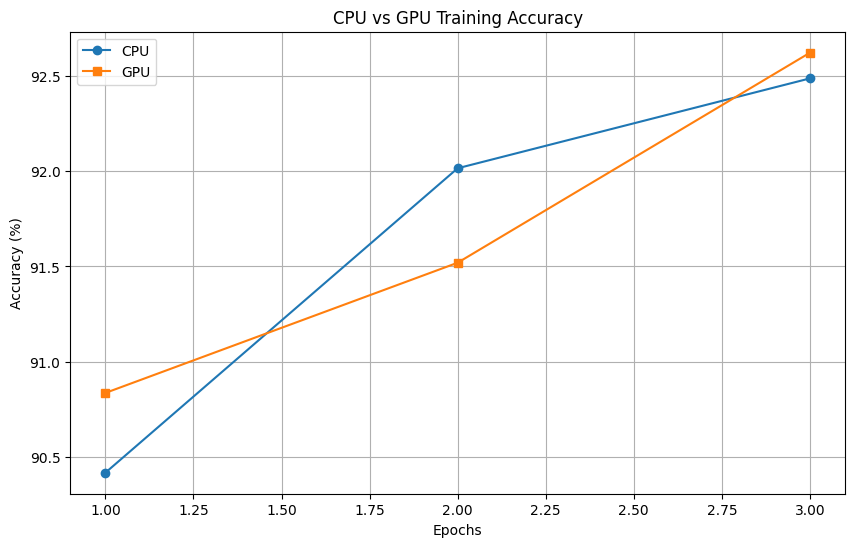

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
import matplotlib.pyplot as plt

# 定義神經網絡模型
class LetterNet(nn.Module):
    def __init__(self):
        super(LetterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 26)  # 26個英文字母

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# 訓練函數
def train(model, device, train_loader, optimizer, epoch):
    model.train()


    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'訓練進度: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]')
            if device.type == "cuda":
                print(f"[GPU] 使用記憶體: {torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
                print(f"[GPU] 最⼤使⽤記憶體: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MiB")

# 測試函數
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'測試集: 平均損失: {test_loss:.4f}, 準確率: {correct}/{len(test_loader.dataset)} ({accuracy:.1f}%)')
    return accuracy

# 轉換EMNIST數據集的標籤（1-26 → 0-25）
def emnist_target_transform(target):
    return target - 1

# 訓練模型並計時
def train_model(device_name, epochs=5):
    if device_name == "cuda" and not torch.cuda.is_available():
        print("CUDA不可用，切換到CPU訓練")
        device_name = "cpu"
    device = torch.device(device_name)
    print(f"使用{device_name}進行訓練")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.EMNIST(
        '../data', split='letters', train=True, download=True,
        transform=transform, target_transform=emnist_target_transform
    )
    test_dataset = datasets.EMNIST(
        '../data', split='letters', train=False,
        transform=transform, target_transform=emnist_target_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000)

    model = LetterNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()
    accuracies = []

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        train(model, device, train_loader, optimizer, epoch)
        accuracy = test(model, device, test_loader)
        accuracies.append(accuracy)
        epoch_end = time.time()
        print(f"第{epoch}輪訓練用時: {epoch_end - epoch_start:.2f}秒")

    total_time = time.time() - start_time
    print(f"總訓練時間: {total_time:.2f}秒")

    os.makedirs('models', exist_ok=True)
    model_path = f"models/letter_model_{device_name}.pt"
    torch.save(model.state_dict(), model_path)
    print(f"模型已保存到 {model_path}")

    return total_time, accuracies

# 主函數
def main():
    epochs = 3

    cpu_time, cpu_accuracies = train_model("cpu", epochs)
    gpu_time, gpu_accuracies = train_model("cuda", epochs)

    speedup = cpu_time / gpu_time if gpu_time > 0 else float('inf')

    with open("training_comparison.txt", "w") as f:
        f.write("英文字母識別模型訓練時間比較\n")
        f.write("=" * 40 + "\n")
        f.write(f"訓練輪數: {epochs}\n\n")
        f.write("CPU訓練:\n")
        f.write(f"  - 總時間: {cpu_time:.2f}秒\n")
        f.write(f"  - 最終準確率: {cpu_accuracies[-1]:.2f}%\n\n")
        f.write("GPU訓練:\n")
        f.write(f"  - 總時間: {gpu_time:.2f}秒\n")
        f.write(f"  - 最終準確率: {gpu_accuracies[-1]:.2f}%\n\n")
        f.write(f"GPU加速比: {speedup:.2f}x\n")
        f.write("=" * 40 + "\n")
        f.write("\n每輪訓練準確率:\n")
        f.write("輪數\tCPU準確率\tGPU準確率\n")
        for i in range(epochs):
            f.write(f"{i+1}\t{cpu_accuracies[i]:.2f}%\t{gpu_accuracies[i]:.2f}%\n")

    print(f"比較結果已保存到 'training_comparison.txt'")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), cpu_accuracies, marker='o', label='CPU')
    plt.plot(range(1, epochs + 1), gpu_accuracies, marker='s', label='GPU')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('CPU vs GPU Training Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_comparison.png')
    print("準確率比較圖已保存到 'accuracy_comparison.png'")

if __name__ == '__main__':
    main()


In [ ]:
import os
drive_path = '/content/drive/My Drive/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Check if the Drive path exists
if os.path.exists(drive_path):
    print("Google Drive is mounted successfully.")

    # List items in your main Drive folder
    print("Items in your Drive:")
    for item in os.listdir(drive_path):
        print(item)
else:
    print("Google Drive is not mounted or the path is incorrect.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive is mounted successfully.
Items in your Drive:
Colab Notebooks
forward.gsheet
frm比重OTC_1_選擇權評價_binomial_model Exchange_Margin_Account_Balance swap i.gsheet
future 期貨價格.gsheet
Hedge .gsheet
Option Greek Delta.gsheet
Option Greek Theta.gsheet
option Standard error_cheaptest to deliver_ Geometric Brownian motion_ Margin Account Balance__Optimal hedge Ratio_Callable Bond_ protected put_ covered Call_ Future_ forward foreign Exchange Rate_ swap.gsheet
portofolio yieled portofolio duration.gsheet
Present Value _Bayes Theorem_Standard error_cheaptest to deliver_ Geometric Brownian motion_Margin Account Balance_Optimal hedge Ratio_Optimal hedge Ratio_Call.gsheet
put price within forward.gsheet
spot rate forward rate par yield discount function (2).gsheet
spot rate forward rate par yield discount function.gsheet
study-note binomial black shloe yiel put cal

In [ ]:
# Define the path to a specific folder in your Drive
project_folder_path = os.path.join(drive_path, 'my_project') # Creates '/content/drive/My Drive/my_project'

# Check if the project folder exists and list its contents
if os.path.exists(project_folder_path):
    print(f"\nItems in '{project_folder_path}':")
    for item in os.listdir(project_folder_path):
        print(item)

    # Define the path to a specific file
    data_file_path = os.path.join(project_folder_path, 'data.csv') # Creates '/content/drive/My Drive/my_project/data.csv'

    # Check if the data file exists
    if os.path.exists(data_file_path):
        print(f"\nData file found at: {data_file_path}")

        # Example: Reading a file from Drive (if it's a text file)
        try:
            with open(data_file_path, 'r') as f:
                first_line = f.readline()
                print(f"First line of {os.path.basename(data_file_path)}: {first_line.strip()}")
        except FileNotFoundError:
            print(f"Error: File not found at {data_file_path}")
        except Exception as e:
            print(f"An error occurred while reading the file: {e}")
    else:
        print(f"\nData file not found at: {data_file_path}")

else:
    print(f"\nProject folder not found at: {project_folder_path}")


Items in '/content/drive/My Drive/my_project':
data.csv

Data file found at: /content/drive/My Drive/my_project/data.csv
First line of data.csv: Keyword,Frequency


In [ ]:
import os

# Assuming drive_path is already defined, e.g.:
# drive_path = '/content/drive/My Drive/'

# Define the path to a specific folder in your Drive
project_folder_path = os.path.join(drive_path, 'my_project') # Creates '/content/drive/My Drive/my_project'

# Check if the project folder exists
if os.path.exists(project_folder_path):
    print(f"\nAccessing folder: '{project_folder_path}'")

    # Define the path to the specific file
    data_file_path = os.path.join(project_folder_path, 'data.csv') # Creates '/content/drive/My Drive/my_project/data.csv'

    # Check if the data file exists
    if os.path.exists(data_file_path):
        print(f"\nData file found at: {data_file_path}")

        # --- CHANGE STARTS HERE ---
        # Read and print the entire content of the file
        try:
            with open(data_file_path, 'r') as f:
                print(f"\n--- Content of {os.path.basename(data_file_path)} ---")
                file_content = f.read() # Read the entire file content
                print(file_content)      # Print the content
                print("--- End of file ---")

        except FileNotFoundError:
            print(f"Error: File not found at {data_file_path}")
        except Exception as e:
            print(f"An error occurred while reading the file: {e}")
        # --- CHANGE ENDS HERE ---

    else:
        print(f"\nData file not found at: {data_file_path}. Make sure 'data.csv' is in 'my_project'.")

else:
    print(f"\nProject folder not found at: {project_folder_path}. Make sure 'my_project' folder exists in your Drive.")


Accessing folder: '/content/drive/My Drive/my_project'

Data file found at: /content/drive/My Drive/my_project/data.csv

--- Content of data.csv ---
Keyword,Frequency
ABI (application binary interface),1
deploying sample betting application,1
fast-track application tutorial,1
...,1
Zennet,1
“zero-client” gateway,1

--- End of file ---
